In [ ]:
!pip install transformers
!pip install torch          # For PyTorch
!pip install tensorflow     # For TensorFlow
!pip install numpy
!pip install pandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import transformers
import torch
import tensorflow as tf
import numpy as np
import pandas as pd

In [ ]:
from transformers import RobertaModel, RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('pdelobelle/robbert-v2-dutch-base')
model = RobertaModel.from_pretrained('pdelobelle/robbert-v2-dutch-base')


Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

In [ ]:
import pandas as pd

simlex = pd.read_csv('/content/sample_data/SimLex-999-Dutch-final.txt', sep='\t')


In [ ]:
from transformers import BertModel, BertTokenizer
import torch
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr

# Load the pre-trained model and the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('pdelobelle/robbert-v2-dutch-base')
model = RobertaModel.from_pretrained('pdelobelle/robbert-v2-dutch-base', output_hidden_states=True)

def get_word_embedding(word, layer_num):
    inputs = tokenizer(word, return_tensors='pt')
    outputs = model(**inputs)
    # Use the hidden state from the specified layer as word embedding
    embeddings = outputs.hidden_states[layer_num]
    # Get the mean of the token vectors
    word_embedding = torch.mean(embeddings[0], dim=0)
    # Detach the tensor from the computational graph before converting into a numpy array
    word_embedding = word_embedding.detach().numpy()
    return word_embedding

def calculate_similarity(word1, word2, layer_num):
    word1_embedding = get_word_embedding(word1, layer_num)
    word2_embedding = get_word_embedding(word2, layer_num)
    similarity = 1 - cosine(word1_embedding, word2_embedding)
    return similarity

for layer_num in range(13):  # For BERT base models, there are 13 layers including the output layer
    similarity_scores = []
    for _, row in simlex.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, layer_num)
        similarity_scores.append(similarity)

    simlex[f'predicted_similarity_layer_{layer_num}'] = similarity_scores

    # Assuming 'SimLex999' column contains the true similarity scores
    correlation, _ = spearmanr(simlex['SimLex999'], simlex[f'predicted_similarity_layer_{layer_num}'])
    print(f'Layer {layer_num} - Spearman correlation: {correlation:.3f}')


Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream

KeyboardInterrupt: ignored

In [ ]:
from transformers import BertModel, BertTokenizer
import torch
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr


# Load the pre-trained model and the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('pdelobelle/robbert-v2-dutch-base')
model = RobertaModel.from_pretrained('pdelobelle/robbert-v2-dutch-base', output_hidden_states=True)

def get_word_embedding(word, layer_num):
    inputs = tokenizer(word, return_tensors='pt')
    outputs = model(**inputs)
    # Use the hidden state from the specified layer as word embedding
    embeddings = outputs.hidden_states[layer_num]
    # Get the mean of the token vectors
    word_embedding = torch.mean(embeddings[0], dim=0)
    # Detach the tensor from the computational graph before converting into a numpy array
    word_embedding = word_embedding.detach().numpy()
    return word_embedding

def calculate_similarity(word1, word2, layer_num):
    word1_embedding = get_word_embedding(word1, layer_num)
    word2_embedding = get_word_embedding(word2, layer_num)
    similarity = 1 - cosine(word1_embedding, word2_embedding)
    return similarity

spearman_results = []  # A list to store the Spearman correlations

for layer_num in range(13):  # For BERT base models, there are 13 layers including the output layer
    similarity_scores = []
    for _, row in simlex.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, layer_num)
        similarity_scores.append(similarity)

    simlex[f'predicted_similarity_layer_{layer_num}'] = similarity_scores

    # Assuming 'SimLex999' column contains the true similarity scores
    correlation, _ = spearmanr(simlex['SimLex999'], simlex[f'predicted_similarity_layer_{layer_num}'])
    spearman_results.append(correlation)
    print(f'Layer {layer_num} - Spearman correlation: {correlation:.3f}')

# Plotting
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x=list(range(13)), y=spearman_results, palette="Blues_d", ax=ax, edgecolor='black')
ax.set_title('Spearman Correlation Across Transformer Layers', fontsize=14, fontweight='bold')
ax.set_xlabel('Transformer Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')
ax.grid(True)
sns.despine()
plt.show()


Some weights of the model checkpoint at pdelobelle/robbert-v2-dutch-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream

Layer 0 - Spearman correlation: 0.037
Layer 1 - Spearman correlation: 0.047
Layer 2 - Spearman correlation: 0.026
Layer 3 - Spearman correlation: 0.016
Layer 4 - Spearman correlation: 0.032
Layer 5 - Spearman correlation: 0.031
Layer 6 - Spearman correlation: 0.044
Layer 7 - Spearman correlation: 0.008
Layer 8 - Spearman correlation: 0.005
Layer 9 - Spearman correlation: 0.010
Layer 10 - Spearman correlation: 0.008
Layer 11 - Spearman correlation: 0.007
Layer 12 - Spearman correlation: 0.063


NameError: ignored

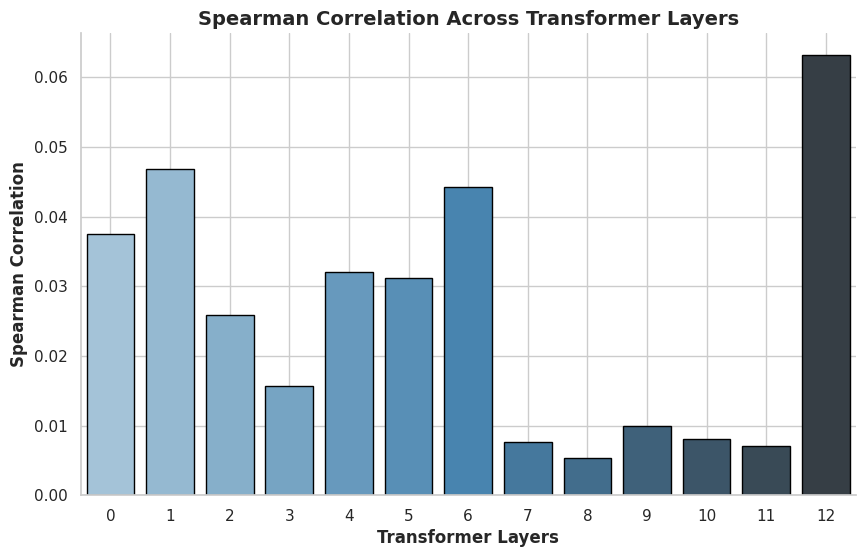

In [ ]:
import torch
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x=list(range(13)), y=spearman_results, palette="Blues_d", ax=ax, edgecolor='black')
ax.set_title('Spearman Correlation Across Transformer Layers', fontsize=14, fontweight='bold')
ax.set_xlabel('Transformer Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')
ax.grid(True)
sns.despine()
plt.show()

In [ ]:
# import torch
# from scipy.spatial.distance import cosine

# def get_word_embedding(word):
#     inputs = tokenizer(word, return_tensors='pt')
#     outputs = model(**inputs)
#     # Use the last hidden state as word embedding
#     embeddings = outputs.last_hidden_state
#     # Get the mean of the token vectors
#     word_embedding = torch.mean(embeddings[0], dim=0)
#     # Detach the tensor from the computational graph before converting into a numpy array
#     word_embedding = word_embedding.detach().numpy()
#     return word_embedding

# def calculate_similarity(word1, word2):
#     word1_embedding = get_word_embedding(word1)
#     word2_embedding = get_word_embedding(word2)
#     similarity = 1 - cosine(word1_embedding, word2_embedding)
#     return similarity

In [ ]:
from transformers import BertModel, BertTokenizer
import torch
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr

# Load the pre-trained model and the tokenizer
tokenizer = BertTokenizer.from_pretrained('wietsedv/bert-base-dutch-cased')
model = BertModel.from_pretrained('wietsedv/bert-base-dutch-cased', output_hidden_states=True)

def get_word_embedding(word, layer_nums):
    inputs = tokenizer(word, return_tensors='pt')
    outputs = model(**inputs)
    # Use the hidden state from the specified layers as word embedding
    embeddings = [outputs.hidden_states[i] for i in layer_nums]
    # Average the embeddings from the specified layers
    averaged_embedding = torch.mean(torch.stack(embeddings), dim=0)
    # Get the mean of the token vectors
    word_embedding = torch.mean(averaged_embedding[0], dim=0)
    # Detach the tensor from the computational graph before converting into a numpy array
    word_embedding = word_embedding.detach().numpy()
    return word_embedding

def calculate_similarity(word1, word2, layer_nums):
    word1_embedding = get_word_embedding(word1, layer_nums)
    word2_embedding = get_word_embedding(word2, layer_nums)
    similarity = 1 - cosine(word1_embedding, word2_embedding)
    return similarity

# Specify the layers you want to combine
layer_nums = [1, 12]

similarity_scores = []
for _, row in simlex.iterrows():
    word1 = row['word1']
    word2 = row['word2']
    similarity = calculate_similarity(word1, word2, layer_nums)
    similarity_scores.append(similarity)

simlex['predicted_similarity'] = similarity_scores

# Assuming 'SimLex999' column contains the true similarity scores
correlation, _ = spearmanr(simlex['SimLex999'], simlex['predicted_similarity'])
print(f'Layers {layer_nums} - Spearman correlation: {correlation:.3f}')


Some weights of the model checkpoint at wietsedv/bert-base-dutch-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at wietsedv/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

Layers [1, 12] - Spearman correlation: 0.280


In [ ]:
from scipy.stats import spearmanr

# Assuming 'SimLex999' column contains the true similarity scores
correlation, _ = spearmanr(simlex['SimLex999'], simlex['predicted_similarity'])
print(f'Spearman correlation: {correlation:.3f}')


Spearman correlation: 0.280


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler object that will scale values to range from 0 to 10
scaler = MinMaxScaler(feature_range=(0, 10))

# Fit the scaler on the predicted similarity scores and transform them
simlex['predicted_similarity_scaled'] = scaler.fit_transform(simlex[['predicted_similarity']])


In [ ]:
# Compute absolute differences between predicted and actual scores
simlex['abs_diff'] = abs(simlex['SimLex999'] - simlex['predicted_similarity'])

# Sort by absolute differences
simlex_sorted = simlex.sort_values('abs_diff', ascending=False)

# Print out the word pairs with the largest differences
print(simlex_sorted[['word1', 'word2', 'SimLex999', 'predicted_similarity', 'predicted_similarity_scaled']].head(10))


         word1        word2  SimLex999  predicted_similarity  \
370       arts       dokter       9.28              0.875867   
28   eenvoudig  gemakkelijk       9.04              0.839119   
87     angstig         bang       9.06              0.873491   
22        vlug         snel       8.95              0.795370   
840  deelnemen      meedoen       8.90              0.858656   
155   boosheid        woede       8.87              0.862360   
788    creëren        maken       8.76              0.819627   
335     koppel         paar       8.56              0.754676   
236    bedrijf  onderneming       8.72              0.922419   
692      beest         dier       8.59              0.813030   

     predicted_similarity_scaled  
370                     8.065729  
28                      6.942358  
87                      7.993075  
22                      5.604964  
840                     7.539579  
155                     7.652824  
788                     6.346489  
335            

In [ ]:
# Group by POS and compute mean difference for each group
grouped = simlex.groupby('POS')['abs_diff'].mean()

# Print out the mean difference for each POS
print(grouped)

POS
A    3.310218
N    2.840209
V    2.730737
Name: abs_diff, dtype: float64


In [ ]:
# Select the adjective pairs with the largest differences
adjectives = simlex[simlex['POS'] == 'A']
adjectives_sorted = adjectives.sort_values('abs_diff', ascending=False)
print('Adjective pairs with largest differences:')
print(adjectives_sorted[['word1', 'word2', 'SimLex999', 'predicted_similarity']].head(10))

# Select the noun pairs with the largest differences
nouns = simlex[simlex['POS'] == 'N']
nouns_sorted = nouns.sort_values('abs_diff', ascending=False)
print('\nNoun pairs with largest differences:')
print(nouns_sorted[['word1', 'word2', 'SimLex999', 'predicted_similarity']].head(10))

# Select the verb pairs with the largest differences
verbs = simlex[simlex['POS'] == 'V']
verbs_sorted = verbs.sort_values('abs_diff', ascending=False)
print('\nVerb pairs with largest differences:')
print(verbs_sorted[['word1', 'word2', 'SimLex999', 'predicted_similarity']].head(10))


Adjective pairs with largest differences:
           word1         word2  SimLex999  predicted_similarity
28     eenvoudig   gemakkelijk       9.04              0.839119
87       angstig          bang       9.06              0.873491
22          vlug          snel       8.95              0.795370
62      cruciaal    belangrijk       8.59              0.821045
59    essentieel  noodzakelijk       8.55              0.824733
25   eigenaardig        vreemd       8.56              0.874668
33          raar        vreemd       8.40              0.899722
52  noodzakelijk    belangrijk       8.22              0.767782
1           slim   intelligent       8.19              0.832312
71         bizar        vreemd       8.11              0.829743

Noun pairs with largest differences:
        word1         word2  SimLex999  predicted_similarity
370      arts        dokter       9.28              0.875867
155  boosheid         woede       8.87              0.862360
335    koppel          paar      

In [ ]:
pos_categories = ["A", "N", "V"]
for pos in pos_categories:
    pos_data = simlex[simlex['POS'] == pos]
    spearman_corr = pos_data['SimLex999'].corr(pos_data['predicted_similarity'], method='spearman')
    print(f"Spearman correlation for {pos}: {spearman_corr}")


Spearman correlation for A: 0.3899102292970155
Spearman correlation for N: 0.33613713944627127
Spearman correlation for V: 0.0422509181099498


In [ ]:
simlex['abs_diff'] = abs(simlex['SimLex999'] - simlex['predicted_similarity'])
largest_diff = simlex.nlargest(10, 'abs_diff')
print(largest_diff)


         word1        word2  SimLex999 POS  predicted_similarity_layer_0  \
370       arts       dokter       9.28   N                      0.848842   
28   eenvoudig  gemakkelijk       9.04   A                      0.847455   
87     angstig         bang       9.06   A                      0.809990   
22        vlug         snel       8.95   A                      0.875864   
840  deelnemen      meedoen       8.90   V                      0.774612   
155   boosheid        woede       8.87   N                      0.753876   
788    creëren        maken       8.76   V                      0.776372   
335     koppel         paar       8.56   N                      0.784778   
236    bedrijf  onderneming       8.72   N                      0.852805   
692      beest         dier       8.59   N                      0.839207   

     predicted_similarity_layer_1  predicted_similarity_layer_2  \
370                      0.855517                      0.882763   
28                       0.83

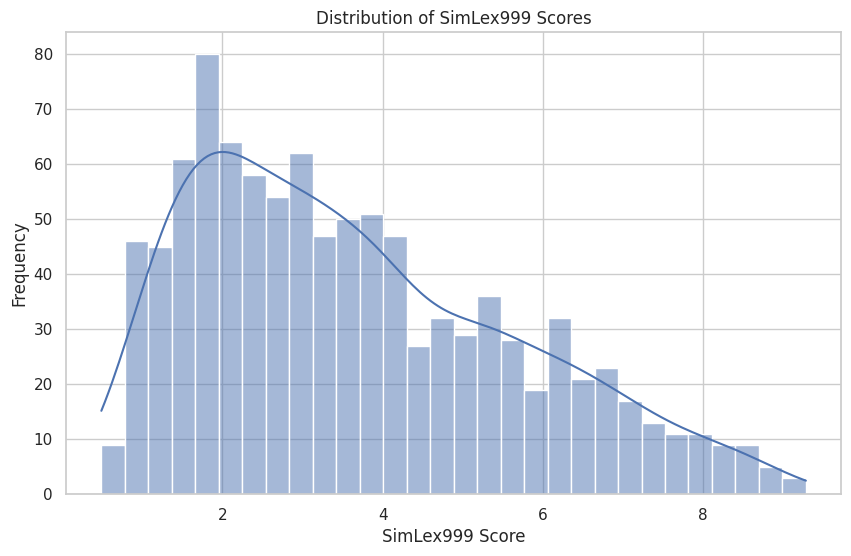

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram for SimLex999 scores
plt.figure(figsize=(10,6))
sns.histplot(data=simlex, x="SimLex999", bins=30, kde=True)
plt.title("Distribution of SimLex999 Scores")
plt.xlabel("SimLex999 Score")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Lees de SUBTLEX-NL gegevens
subtlex_nl = pd.read_csv('/content/sample_data/SUBTLEX-NL-New.txt', sep='\t')

# Maak een woordenboek dat de frequentie van elk woord opslaat
word_frequencies = subtlex_nl.set_index('Word')['FREQcount'].to_dict()

# Nu kun je de frequenties uit dit woordenboek gebruiken in plaats van de willekeurige frequenties


<ipython-input-26-03d59771aca7>:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  subtlex_nl = pd.read_csv('/content/sample_data/SUBTLEX-NL-New.txt', sep='\t')


In [ ]:
# Add frequency data to SimLex999 DataFrame
simlex['frequency1'] = simlex['word1'].map(word_frequencies)
simlex['frequency2'] = simlex['word2'].map(word_frequencies)

# Calculate median frequency
median_freq = simlex[['frequency1', 'frequency2']].median().mean()

# Split into high frequency and low frequency subsets
simlex_high_freq = simlex[(simlex['frequency1'] > median_freq) & (simlex['frequency2'] > median_freq)]
simlex_low_freq = simlex[(simlex['frequency1'] <= median_freq) & (simlex['frequency2'] <= median_freq)]

# Specify the layers you want to combine
layer_nums = [1, 12]

for simlex_subset, freq in zip([simlex_high_freq, simlex_low_freq], ['high', 'low']):
    similarity_scores = []
    for _, row in simlex_subset.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, layer_nums)
        similarity_scores.append(similarity)

    simlex_subset['predicted_similarity'] = similarity_scores

    # Assuming 'SimLex999' column contains the true similarity scores
    correlation, _ = spearmanr(simlex_subset['SimLex999'], simlex_subset['predicted_similarity'])
    print(f'Layers {layer_nums} - Spearman correlation for {freq} frequency words: {correlation:.3f}')


<ipython-input-27-ab7066b4b9b7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simlex_subset['predicted_similarity'] = similarity_scores


Layers [1, 12] - Spearman correlation for high frequency words: 0.325
Layers [1, 12] - Spearman correlation for low frequency words: 0.329


In [ ]:
simlex_high_freq = simlex[(simlex['frequency1'] > median_freq) & (simlex['frequency2'] > median_freq)].copy()
simlex_low_freq = simlex[(simlex['frequency1'] <= median_freq) & (simlex['frequency2'] <= median_freq)].copy()


In [ ]:
# Calculate the Spearman correlation for each layer and each frequency group
for layer_num in range(13):  # For BERT base models, there are 13 layers including the output layer
    similarity_scores_high = []
    similarity_scores_low = []

    for _, row in simlex_high_freq.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, [layer_num])
        similarity_scores_high.append(similarity)

    for _, row in simlex_low_freq.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, [layer_num])
        similarity_scores_low.append(similarity)

    simlex_high_freq['predicted_similarity'] = similarity_scores_high
    simlex_low_freq['predicted_similarity'] = similarity_scores_low

    correlation_high, _ = spearmanr(simlex_high_freq['SimLex999'], simlex_high_freq['predicted_similarity'])
    correlation_low, _ = spearmanr(simlex_low_freq['SimLex999'], simlex_low_freq['predicted_similarity'])

    print(f'Layer {layer_num} - Spearman correlation for high frequency words: {correlation_high:.3f}')
    print(f'Layer {layer_num} - Spearman correlation for low frequency words: {correlation_low:.3f}')


Layer 0 - Spearman correlation for high frequency words: 0.412
Layer 0 - Spearman correlation for low frequency words: 0.280
Layer 1 - Spearman correlation for high frequency words: 0.291
Layer 1 - Spearman correlation for low frequency words: 0.258
Layer 2 - Spearman correlation for high frequency words: 0.289
Layer 2 - Spearman correlation for low frequency words: 0.275
Layer 3 - Spearman correlation for high frequency words: 0.290
Layer 3 - Spearman correlation for low frequency words: 0.289
Layer 4 - Spearman correlation for high frequency words: 0.279
Layer 4 - Spearman correlation for low frequency words: 0.272
Layer 5 - Spearman correlation for high frequency words: 0.304
Layer 5 - Spearman correlation for low frequency words: 0.255
Layer 6 - Spearman correlation for high frequency words: 0.289
Layer 6 - Spearman correlation for low frequency words: 0.254
Layer 7 - Spearman correlation for high frequency words: 0.298
Layer 7 - Spearman correlation for low frequency words: 0.222


NameError: ignored

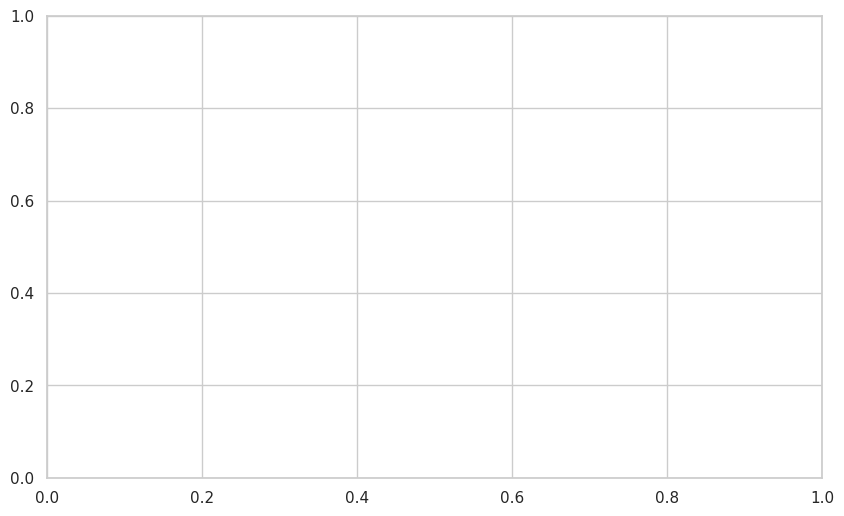

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improving plot aesthetics using Seaborn
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting data with edgecolor and custom colors
ax.bar(range(13), [correlation_high, correlation_low], color=["#1f77b4", "#ff7f0e"], edgecolor='black')

# Adding title and labels
ax.set_title('Spearman Correlation for High and Low Frequency Words by Layer', fontsize=14, fontweight='bold')
ax.set_xlabel('Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')

# Set the xticks to be the layer numbers
ax.set_xticks(range(13))
ax.set_xticklabels(range(13))

# Adding a grid
ax.grid(True)

# Remove top and right borders
sns.despine()

plt.show()


In [ ]:
# Get the vocabulary used by the tokenizer
vocab = tokenizer.get_vocab()

# Create an empty set to store out-of-vocabulary (OOV) words
oov_words = set()

# Check each unique word in the SimLex-999 dataset
for word in pd.concat([simlex['word1'], simlex['word2']]).unique():
    if word not in vocab:
        oov_words.add(word)

print(f'There are {len(oov_words)} out-of-vocabulary words.')
print('Some examples are:', list(oov_words)[:10])

# Remove rows in simlex where either 'word1' or 'word2' is an OOV word
simlex_no_oov = simlex[~simlex['word1'].isin(oov_words) & ~simlex['word2'].isin(oov_words)]
print(f'There are {len(simlex_no_oov)} word pairs without OOV words.')


There are 139 out-of-vocabulary words.
Some examples are: ['rivaal', 'uithoudingsvermogen', 'anatomie', 'os', 'nodig hebben', 'verstikken', 'afwezigheid', 'jachthond', 'legioen', 'besteden']
There are 805 word pairs without OOV words.


There are 556 out-of-vocabulary words.
Some examples are: ['luisteren', 'stemmen op', 'vermenigvuldigen', 'parel', 'verkondigen', 'griep', 'voorspellen', 'klaslokaal', 'perceptie', 'krankzinnig']
There are 318 word pairs without OOV words.


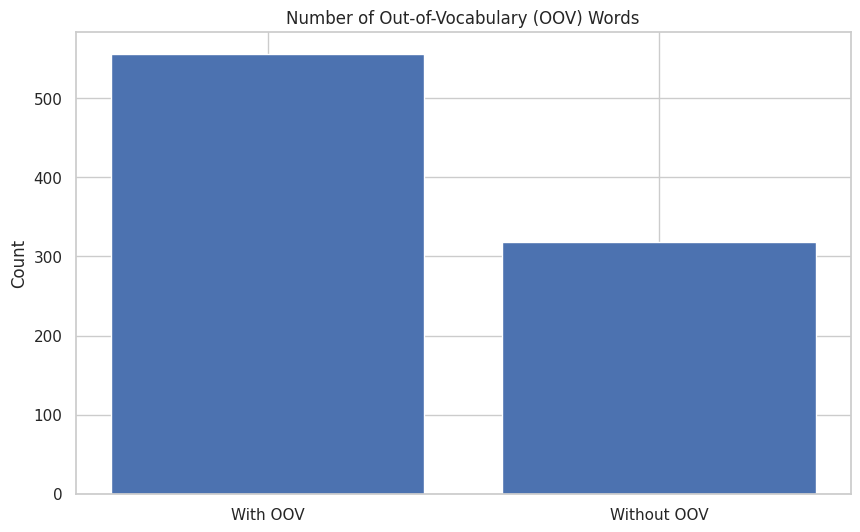

In [ ]:
import matplotlib.pyplot as plt

# Get the vocabulary used by the tokenizer
vocab = tokenizer.get_vocab()

# Create an empty set to store out-of-vocabulary (OOV) words
oov_words = set()

# Check each unique word in the SimLex-999 dataset
for word in pd.concat([simlex['word1'], simlex['word2']]).unique():
    if word not in vocab:
        oov_words.add(word)

print(f'There are {len(oov_words)} out-of-vocabulary words.')
print('Some examples are:', list(oov_words)[:10])

# Remove rows in simlex where either 'word1' or 'word2' is an OOV word
simlex_no_oov = simlex[~simlex['word1'].isin(oov_words) & ~simlex['word2'].isin(oov_words)]
print(f'There are {len(simlex_no_oov)} word pairs without OOV words.')

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the number of OOV words
ax.bar(['With OOV', 'Without OOV'], [len(oov_words), len(simlex_no_oov)])
ax.set_title('Number of Out-of-Vocabulary (OOV) Words')
ax.set_ylabel('Count')

plt.show()


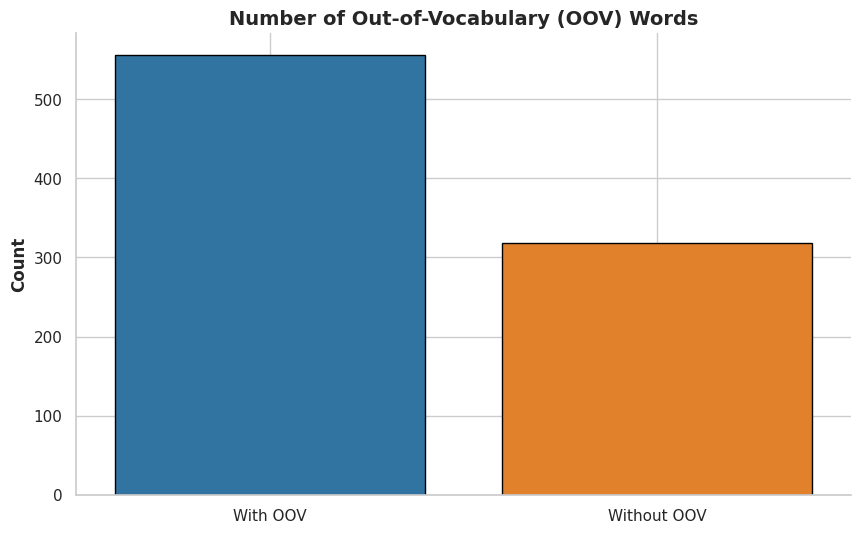

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improving plot aesthetics using Seaborn
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting data with edgecolor and custom colors
ax = sns.barplot(x=['With OOV', 'Without OOV'], y=[len(oov_words), len(simlex_no_oov)], palette=["#1f77b4", "#ff7f0e"], ax=ax, edgecolor='black')

# Adding title and labels
ax.set_title('Number of Out-of-Vocabulary (OOV) Words', fontsize=14, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')

# Adding a grid
ax.grid(True)

# Remove top and right borders
sns.despine()

plt.show()


In [ ]:
def get_word_embedding(word, layer_nums):
    inputs = tokenizer(word, return_tensors='pt')
    outputs = model(**inputs)
    # Check if layer_nums is a list or a single integer
    if isinstance(layer_nums, int):
        layer_nums = [layer_nums]
    # Use the hidden state from the specified layers as word embedding
    embeddings = [outputs.hidden_states[i] for i in layer_nums]
    # Average the embeddings from the specified layers
    averaged_embedding = torch.mean(torch.stack(embeddings), dim=0)
    # Get the mean of the token vectors
    word_embedding = torch.mean(averaged_embedding[0], dim=0)
    # Detach the tensor from the computational graph before converting into a numpy array
    word_embedding = word_embedding.detach().numpy()
    return word_embedding

def calculate_similarity(word1, word2, layer_nums):
    word1_embedding = get_word_embedding(word1, layer_nums)
    word2_embedding = get_word_embedding(word2, layer_nums)
    similarity = 1 - cosine(word1_embedding, word2_embedding)
    return similarity

# Specify the layers you want to combine
layer_nums = [1, 12]

# Calculate the Spearman correlation for each layer and each frequency group
for layer_num in range(13):  # For RobBERT base models, there are 13 layers including the output layer
    similarity_scores = []  # Initialize similarity_scores in each iteration

    for _, row in simlex_no_oov.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, layer_num)
        similarity_scores.append(similarity)

    simlex_no_oov[f'predicted_similarity_layer_{layer_num}'] = similarity_scores

    correlation, _ = spearmanr(simlex_no_oov['SimLex999'], simlex_no_oov[f'predicted_similarity_layer_{layer_num}'])
    print(f'Layer {layer_num} - Spearman correlation (No OOV): {correlation:.3f}')


<ipython-input-31-d54da9d8529d>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simlex_no_oov[f'predicted_similarity_layer_{layer_num}'] = similarity_scores


Layer 0 - Spearman correlation (No OOV): 0.444
Layer 1 - Spearman correlation (No OOV): 0.296
Layer 2 - Spearman correlation (No OOV): 0.294
Layer 3 - Spearman correlation (No OOV): 0.300
Layer 4 - Spearman correlation (No OOV): 0.294
Layer 5 - Spearman correlation (No OOV): 0.308
Layer 6 - Spearman correlation (No OOV): 0.304
Layer 7 - Spearman correlation (No OOV): 0.268
Layer 8 - Spearman correlation (No OOV): 0.263
Layer 9 - Spearman correlation (No OOV): 0.259
Layer 10 - Spearman correlation (No OOV): 0.253
Layer 11 - Spearman correlation (No OOV): 0.252
Layer 12 - Spearman correlation (No OOV): 0.297


In [ ]:
# Specify the layer you want to compute correlation for
layer_num = 0

# Calculate the Spearman correlation for the specified layer
similarity_scores = []  # Initialize similarity_scores

for _, row in simlex_no_oov.iterrows():
    word1 = row['word1']
    word2 = row['word2']
    similarity = calculate_similarity(word1, word2, layer_num)
    similarity_scores.append(similarity)

simlex_no_oov[f'predicted_similarity_layer_{layer_num}'] = similarity_scores

correlation, _ = spearmanr(simlex_no_oov['SimLex999'], simlex_no_oov[f'predicted_similarity_layer_{layer_num}'])
print(f'Layer {layer_num} - Spearman correlation (No OOV): {correlation:.3f}')


Layer 0 - Spearman correlation (No OOV): 0.444


<ipython-input-32-7da999a8262a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simlex_no_oov[f'predicted_similarity_layer_{layer_num}'] = similarity_scores


In [ ]:
from transformers import BertModel, BertTokenizer
import torch
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr

def get_word_embedding(word, layer_nums):
    # Tokenize the word into subtokens and add special tokens [CLS] and [SEP]
    subtokens = [tokenizer.cls_token] + tokenizer.tokenize(word) + [tokenizer.sep_token]
    # Convert subtokens to input IDs
    input_ids = tokenizer.convert_tokens_to_ids(subtokens)
    # Wrap it in a tensor and add an extra batch dimension
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    # Make sure the model does not compute gradients
    with torch.no_grad():
        # Get the model outputs
        outputs = model(input_ids, output_hidden_states=True)
    # Check if layer_nums is a list or a single integer
    if isinstance(layer_nums, int):
        layer_nums = [layer_nums]
    # Use the hidden state from the specified layers as word embedding
    embeddings = [outputs.hidden_states[i] for i in layer_nums]
    # Average the embeddings from the specified layers
    averaged_embedding = torch.mean(torch.stack(embeddings), dim=0)
    # Ignore the first and the last token ([CLS] and [SEP])
    averaged_embedding = averaged_embedding[0, 1:-1]
    # Get the mean of the subtoken vectors to get the word vector
    word_embedding = torch.mean(averaged_embedding, dim=0)
    # Convert tensor to a numpy array
    word_embedding = word_embedding.numpy()
    return word_embedding


def calculate_similarity(word1, word2, layer_nums):
    word1_embedding = get_word_embedding(word1, layer_nums)
    word2_embedding = get_word_embedding(word2, layer_nums)
    similarity = 1 - cosine(word1_embedding, word2_embedding)
    return similarity

# Specify the layers you want to combine
layer_nums = [1, 12]

# Calculate the Spearman correlation for each layer and each frequency group
for layer_num in range(13):  # For RobBERT base models, there are 13 layers including the output layer
    similarity_scores = []  # Initialize similarity_scores in each iteration

    for _, row in simlex.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, layer_num)
        similarity_scores.append(similarity)

    simlex[f'predicted_similarity_layer_{layer_num}'] = similarity_scores
    correlation, _ = spearmanr(simlex['SimLex999'], simlex[f'predicted_similarity_layer_{layer_num}'])
    print(f'Layer {layer_num} - Spearman correlation: {correlation:.3f}')


Layer 0 - Spearman correlation: 0.207
Layer 1 - Spearman correlation: 0.179
Layer 2 - Spearman correlation: 0.124
Layer 3 - Spearman correlation: 0.130
Layer 4 - Spearman correlation: 0.164
Layer 5 - Spearman correlation: 0.187
Layer 6 - Spearman correlation: 0.168
Layer 7 - Spearman correlation: 0.162
Layer 8 - Spearman correlation: 0.160
Layer 9 - Spearman correlation: 0.167
Layer 10 - Spearman correlation: 0.127
Layer 11 - Spearman correlation: 0.082
Layer 12 - Spearman correlation: 0.084


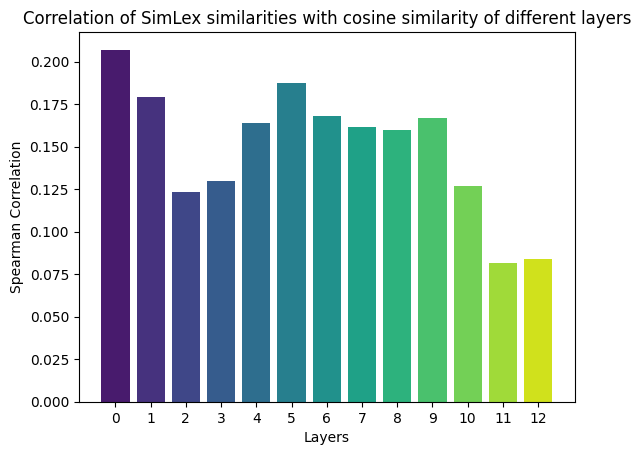

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

correlations = []

# Collect the correlations for each layer
for layer_num in range(13):  # For RobBERT base models, there are 13 layers including the output layer
    correlation, _ = spearmanr(simlex['SimLex999'], simlex[f'predicted_similarity_layer_{layer_num}'])
    correlations.append(correlation)

# Create a figure and axis
fig, ax = plt.subplots()

# Set colors for the layers
colors = sns.color_palette("viridis", len(correlations))

# Bar plot for the layers
ax.bar(range(len(correlations)), correlations, color=colors)

# Set the title and labels
ax.set_title('Correlation of SimLex similarities with cosine similarity of different layers')
ax.set_xlabel('Layers')
ax.set_ylabel('Spearman Correlation')

# Set the xticks to be the layer numbers
ax.set_xticks(range(len(correlations)))
ax.set_xticklabels(range(len(correlations)))

# Show the plot
plt.show()


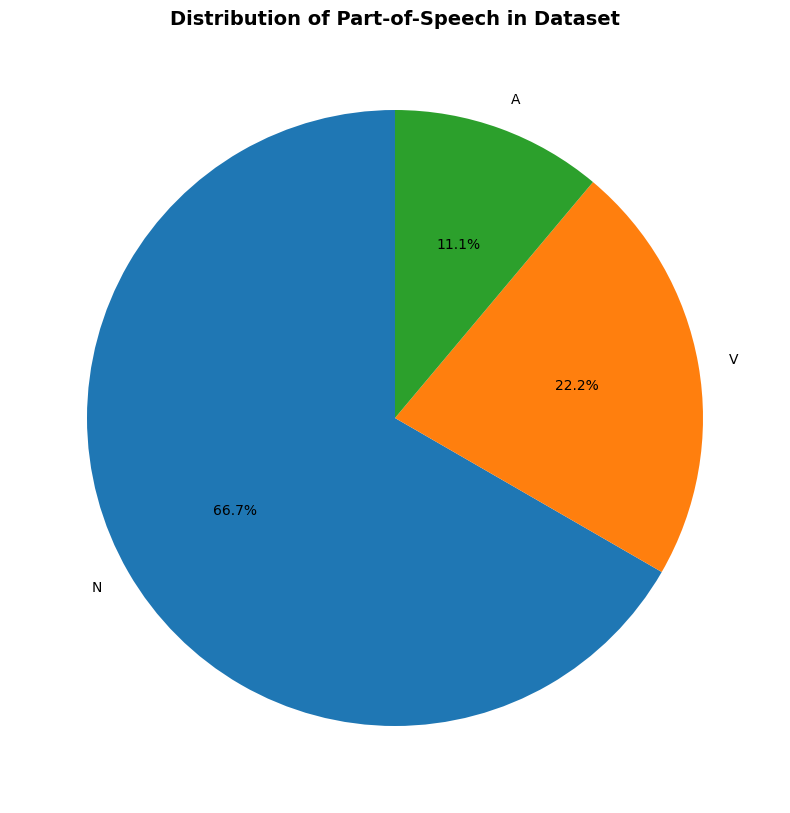

In [ ]:
import matplotlib.pyplot as plt

# Calculate POS frequencies
pos_counts = simlex['POS'].value_counts()

# Plot a pie chart
plt.figure(figsize=(10,10))
plt.pie(pos_counts, labels=pos_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Part-of-Speech in Dataset', fontsize=14, fontweight='bold')
plt.show()


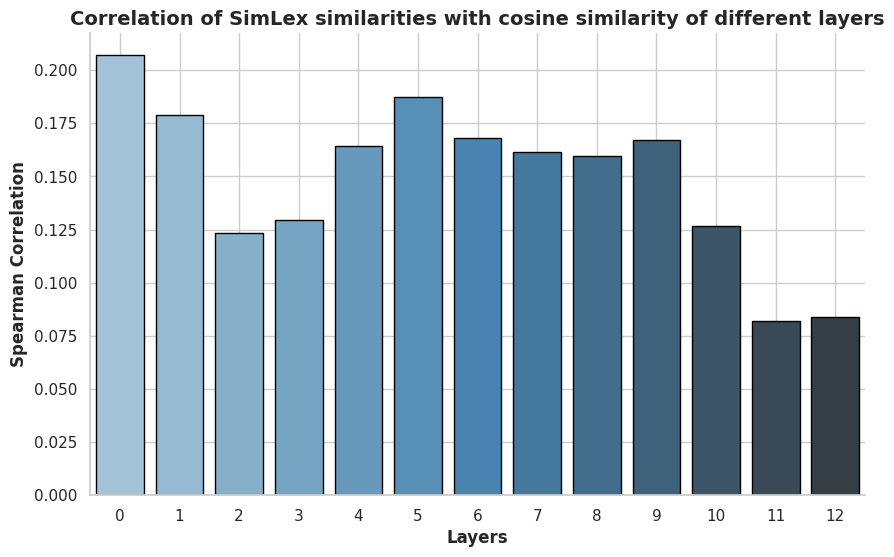

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improving plot aesthetics using Seaborn
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting data with edgecolor
ax = sns.barplot(x=list(range(13)), y=correlations, palette="Blues_d", ax=ax, edgecolor='black')

# Adding title and labels
ax.set_title('Correlation of SimLex similarities with cosine similarity of different layers', fontsize=14, fontweight='bold')
ax.set_xlabel('Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')

# Adding a grid
ax.grid(True)

# Remove top and right borders
sns.despine()

plt.show()


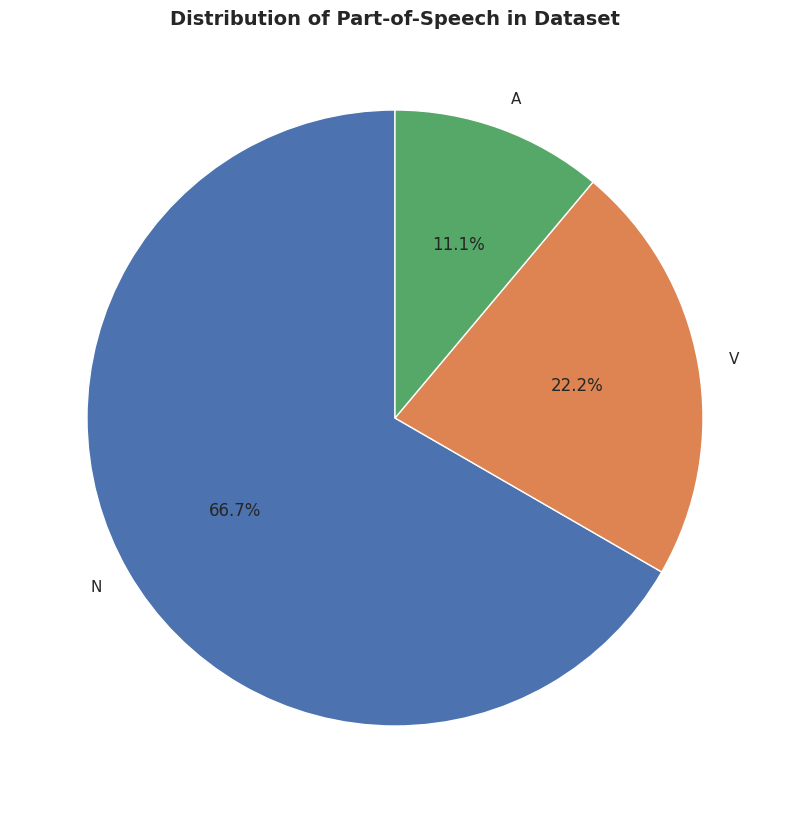

In [ ]:
import matplotlib.pyplot as plt

# Calculate POS frequencies
pos_counts = simlex['POS'].value_counts()

# Plot a pie chart
plt.figure(figsize=(10,10))
plt.pie(pos_counts, labels=pos_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Part-of-Speech in Dataset', fontsize=14, fontweight='bold')
plt.show()



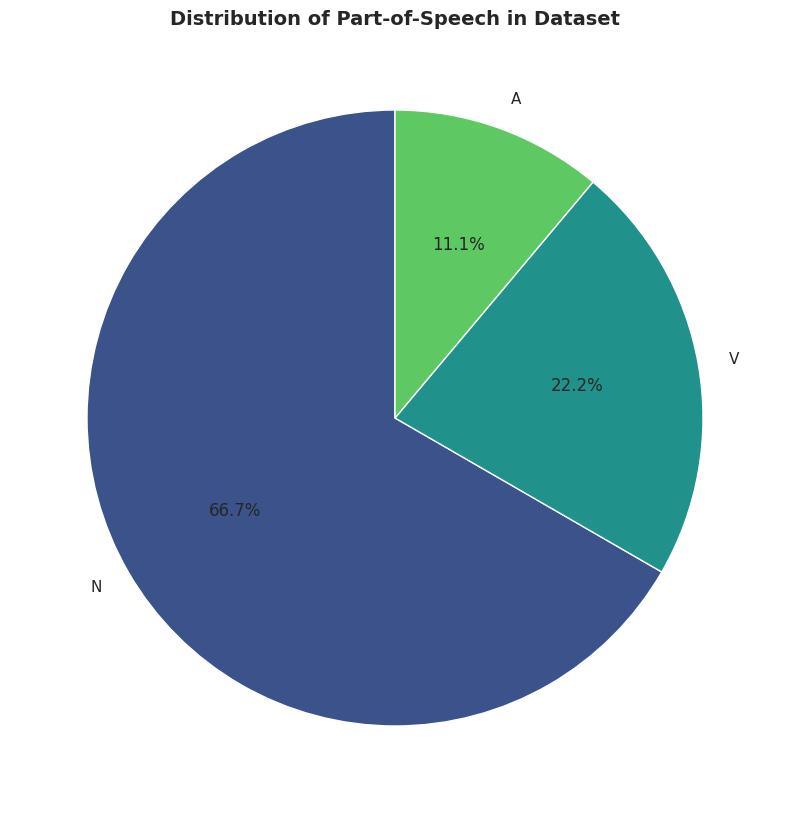

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate POS frequencies
pos_counts = simlex['POS'].value_counts()

# Set colors using Seaborn color palette
colors = sns.color_palette("viridis", len(pos_counts))

# Plot a pie chart
plt.figure(figsize=(10, 10))
plt.pie(pos_counts, labels=pos_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Part-of-Speech in Dataset', fontsize=14, fontweight='bold')
plt.show()


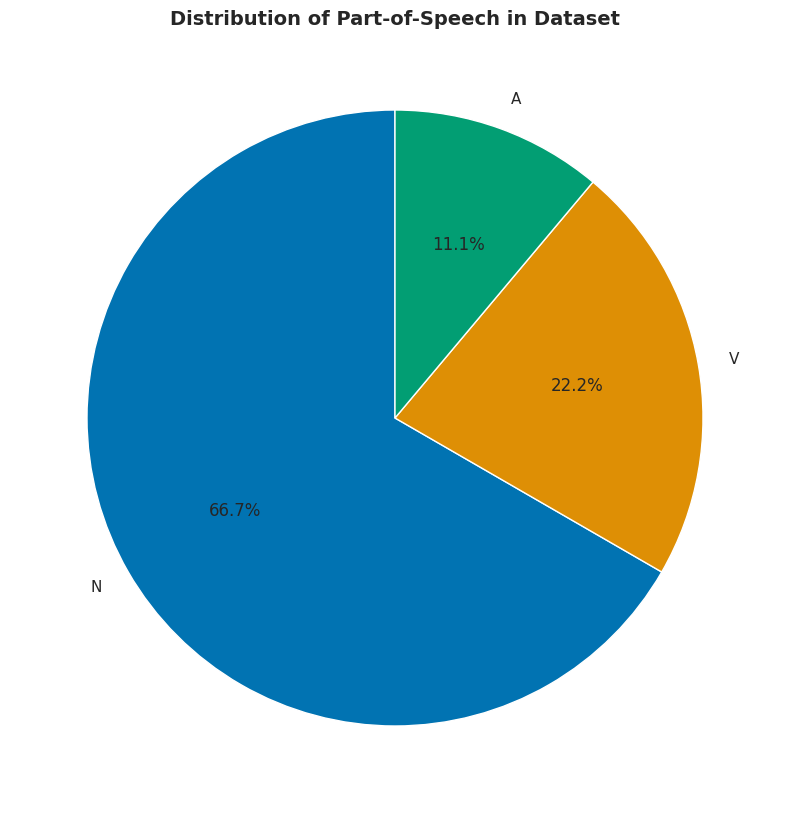

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate POS frequencies
pos_counts = simlex['POS'].value_counts()

# Set colors using a colorblind-friendly palette
colors = sns.color_palette("colorblind", len(pos_counts))

# Plot a pie chart
plt.figure(figsize=(10, 10))
plt.pie(pos_counts, labels=pos_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Part-of-Speech in Dataset', fontsize=14, fontweight='bold')
plt.show()
